# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

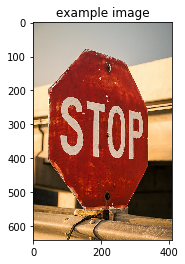

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [186]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'
        
# TODO #3: Select appropriate values for the Python variables below.
embed_size = 1024
hidden_size = 1024

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=2)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
resnet.fc.in_features: 2048
init DecoderRNN. embed_size: 1024, hidden_size: 1024, vocab_size: 8856, num_layers: 2


DecoderRNN(
  (word_embeddings): Embedding(8856, 1024)
  (lstm): LSTM(1024, 1024, num_layers=2, batch_first=True)
  (hidden2tag): Linear(in_features=1024, out_features=8856, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [187]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

#print("data_loader.dataset.vocab.idx2word[0]: {}".format(data_loader.dataset.vocab.idx2word[3]))

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 32, 32, 29, 29, 30, 30, 105, 105, 3, 1871, 5404, 394, 394, 39, 18, 32, 46, 466, 18, 1066, 39, 2635, 46, 2812, 408, 29, 2, 1068, 18]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [188]:
# TODO #4: Complete the function.
def clean_sentence(output):
    
    sentence = ""
    
    for word_int in output:
        sentence = "{} {}".format(sentence, data_loader.dataset.vocab.idx2word[word_int])
    
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [189]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence:  <start> the the stop stop sign sign has has a spray skull painted painted on . the it word . `` on do it n't 's stop <unk> '' .


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [190]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    for i in range(5):
        output = decoder.sample(features)    
        sentence = clean_sentence(output)
        print(sentence)
        print("\n")

Run the code cell below (multiple times, if you like!) to test how this function works.

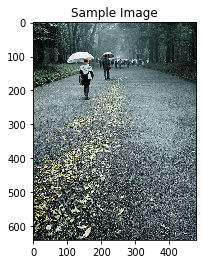

 <start> the a man man flies is his kite balance on on a a beach cloudy <end>


 <start> a a man person flying on a a kite large on , a grass cloudy covered day hillside in . a <end>


 <start> a the man man is in throwing mid his air air while while riding surfing a a small wave wave . in <end>


 <start> a a man person is is standing riding in on a the small beach boat . . there the is dog a on cart a <end>


 <start> a a person man is is on flying the a kite large in kite the <end>




In [194]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

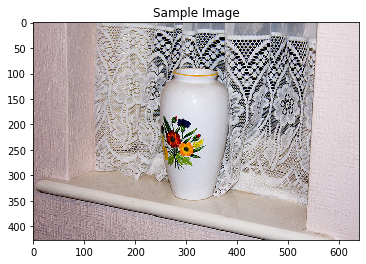

 <start> a the vase vase is with sitting a inside table of and flowers flowers in . the <end>


 <start> three a small vase white with vase a and table a and table white . and and a a plant white in and a a black black and vase


 <start> a the white vase and with a a white flower and in some the water same . . on there the is side a . bottle <end>


 with a a white vase flower holding with a flowers flower in in a it cup . . there in are the on background the <end>


 <start> a a vase vase of filled flowers with with a flowers picture . on it the . side is . on the a side table walk . . it




In [195]:
get_prediction()

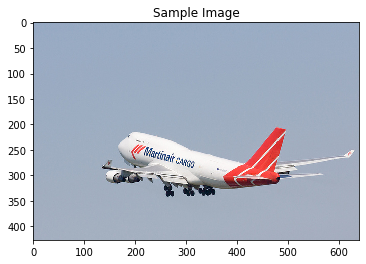

 <start> a an large airplane airplane flying is in against the the blue blue sky sky . . and <end>


 <start> an a airplane large is airplane flying in in a the blue blue and and red white plane , . <end>


 <start> an a air large plane airplane flying is through in a a blue blue sky sky <end>


 plane an in airplane the landing process gear of is the landing <unk> gear . and and the is sun ascending in into the the sky air . . <end>


 <start> an an airplane air is plane flying flying low through over a the runway field . . <end>




In [197]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

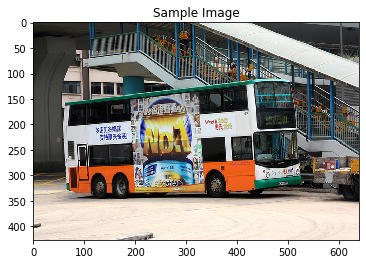

 <start> two a men double are bus <unk> in in a a parking parking lot lot <end>


 <start> a two large level red city bus bus driving parked through in the a city parking . lot <end>


 <start> two a men large are truck walking in in front front . of and the parked city bus . . it <end>


 <start> a two large level red city tour buses bus in parked a city parking street area <end>


 <start> a a bus bus is is parked driving on on a a street city . street <end>




In [198]:
get_prediction()

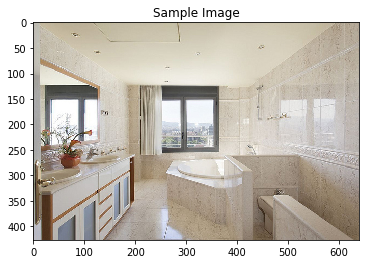

 <start> the the woman bathroom is is clean clean and and ready is for to the use bath . . in <end>


 <start> a a bathroom bathroom has with an a open large window shower . . and and a a toilet white <end>


 <start> a a bathroom bathroom with has two two sinks sinks , and mirrors a . tub <end>


 <start> a a bathroom bathroom has with a a sink tub , , toilet shower , and mirror mirror <end>


 <start> a the bathroom bathroom is is clean shown and and is has ready the to time throw . on . the . counter <end>




In [199]:
get_prediction()